In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

import ddpm
import custom_datasets as datasets

import librosa
import soundfile as sf

# Forward pass

## Dino

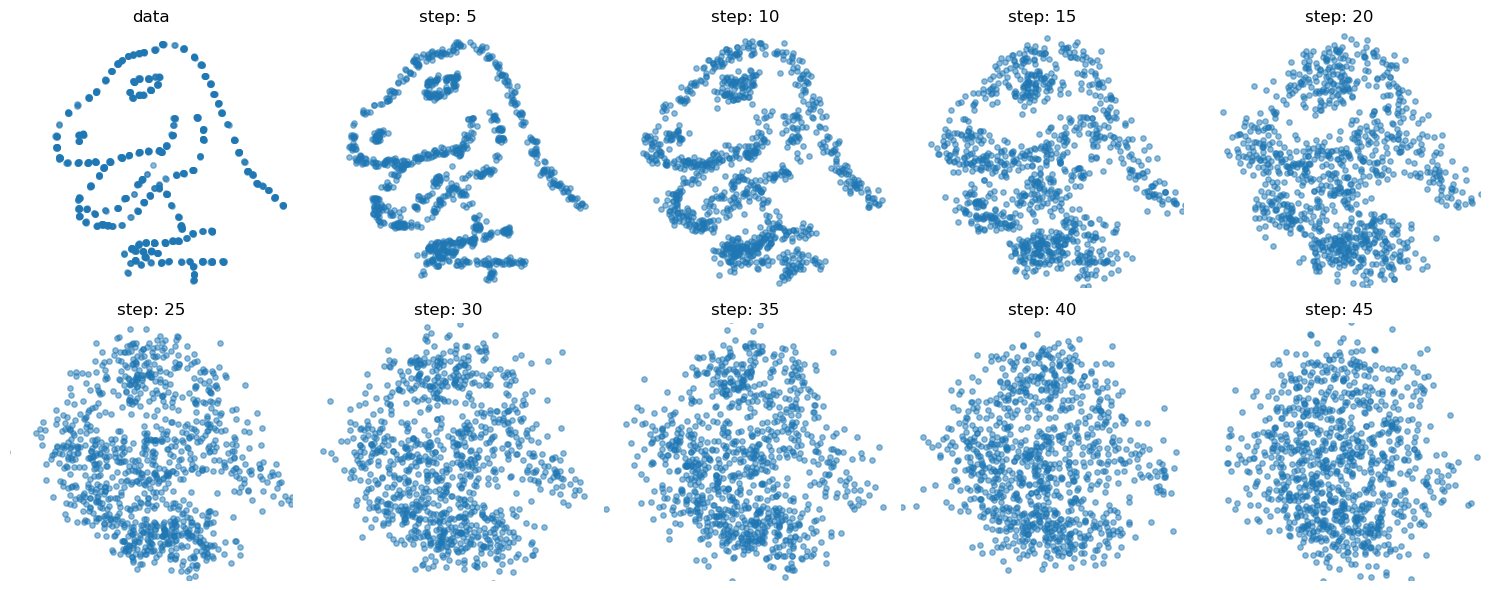

In [ ]:
num_timesteps = 50
plot_step = 5

num_plots = math.ceil(num_timesteps / plot_step)
num_cols = 5
num_rows = math.ceil(num_plots / num_cols)

fig = plt.figure(figsize=(15, 6))

noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
dataset = datasets.get_dataset("dino", n=1000)
x0 = dataset.tensors[0]

plt_cnt = 1
plt.subplot(num_rows, num_cols, plt_cnt)
plt.scatter(x0[:, 0], x0[:, 1], alpha=0.5, s=15)
plt.title("data")
plt.xlim(-3.5, 3.5)
plt.ylim(-4., 4.75)
plt.axis("off")
        
for t in range(len(noise_scheduler)):
    timesteps = np.repeat(t, len(x0))
    noise = torch.randn_like(x0)
    sample = noise_scheduler.add_noise(x0, noise, timesteps).cpu()
    if (t + 1) % plot_step == 0 and (t + 1) != len(noise_scheduler):
        plt_cnt += 1
        plt.subplot(num_rows, num_cols, plt_cnt)
        plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
        plt.title(f"step: {t + 1}")
        plt.xlim(-3.5, 3.5)
        plt.ylim(-4., 4.75)
        plt.axis("off")
        
fig.tight_layout()
plt.savefig("static/forward.png", facecolor="white")
plt.show()

## MNIST

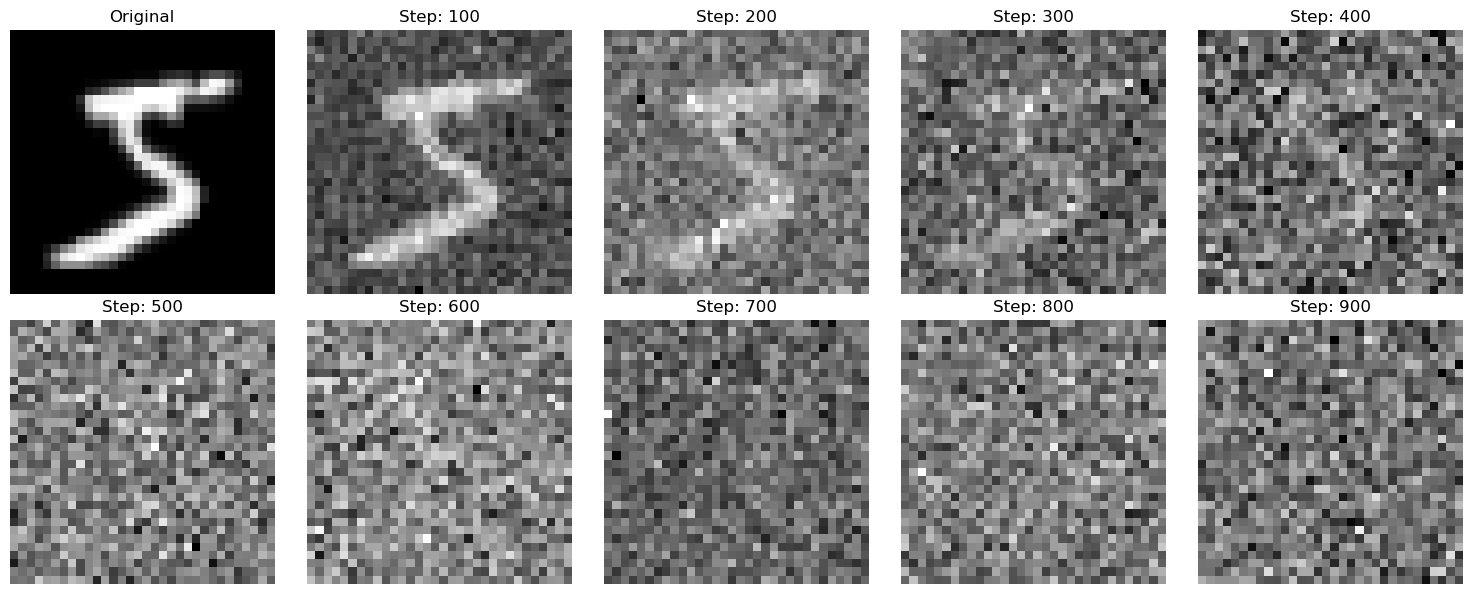

In [4]:
num_timesteps = 1000
plot_step = 100

num_plots = math.ceil(num_timesteps / plot_step)
num_cols = 5
num_rows = math.ceil(num_plots / num_cols)

fig = plt.figure(figsize=(15, 6))

dataset = datasets.get_dataset("mnist", n=1000)
x0, _ = dataset[0]  
x0 = x0.unsqueeze(0) 

noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)

plt_cnt = 1
plt.subplot(num_rows, num_cols, plt_cnt)
plt.imshow(x0.squeeze(0).squeeze(0), cmap="gray")
plt.title("Original")
plt.axis("off")

for t in range(len(noise_scheduler)):
    timesteps = torch.tensor([t]) 
    noise = torch.randn_like(x0) 
    sample = noise_scheduler.add_noise(x0, noise, timesteps).cpu()

    if (t + 1) % plot_step == 0 and (t + 1) != len(noise_scheduler):
        plt_cnt += 1
        plt.subplot(num_rows, num_cols, plt_cnt)
        plt.imshow(sample.squeeze(0).squeeze(0), cmap="gray")
        plt.title(f"Step: {t + 1}")
        plt.axis("off")

fig.tight_layout()
plt.savefig("mnist_forward.png", facecolor="white")
plt.show()


# Reverse diffusion

## Dino

In [36]:
!python ddpm.py --dataset dino --experiment_name dino_base --num_epochs 100 --learning_rate 1e-3 --eval_batch_size 100

Training model...
GPU name: NVIDIA RTX A2000 12GB 

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1044.37it/s]
Saving model...
Saving images...
Saving loss as numpy array...
Saving frames...


In [5]:
model = ddpm.MLP()

path = "exps/dino_base/model.pth"
model.load_state_dict(torch.load(path))
model.eval()

/tmp/ipykernel_238955/1855492978.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


MLP(
  (time_mlp): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (input_mlp1): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (input_mlp2): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (joint_mlp): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate='none')
    )
    (3): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate='none')
    )
    (4): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate='none')
    )
    (5): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [6]:
eval_batch_size = 1000
num_timesteps = 1000
plot_step = 100
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
sample = torch.randn(eval_batch_size, 2)
timesteps = list(range(num_timesteps))[::-1]
samples = []
steps = []
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        residual = model(sample, t)
    sample = noise_scheduler.step(residual, t[0], sample)
    if (i + 1) % plot_step == 0:
        samples.append(sample.cpu().numpy())
        steps.append(i + 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

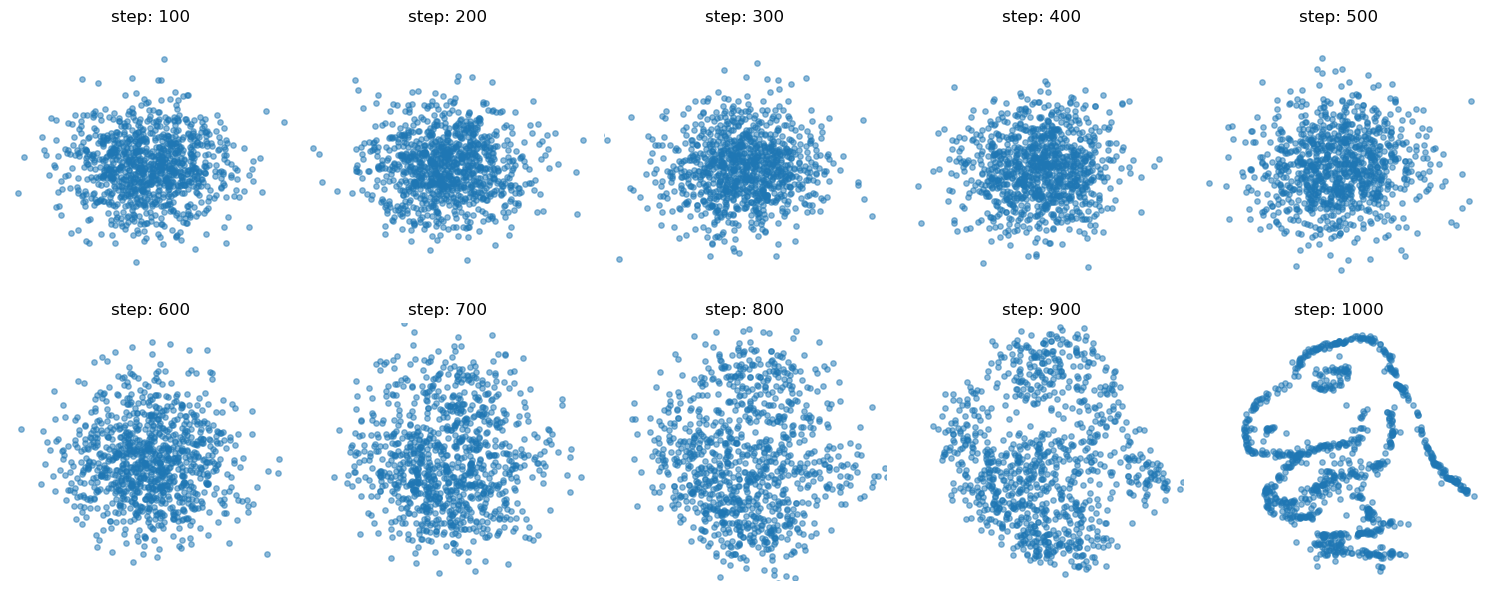

In [43]:
num_cols = 5
num_rows = math.ceil(len(samples) / num_cols)
fig = plt.figure(figsize=(15, 6))
for i, sample in enumerate(samples):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
    plt.title(f"step: {steps[i]}")
    plt.xlim(-3.5, 3.5)
    plt.ylim(-4., 4.75)
    plt.axis("off")
fig.tight_layout()
plt.savefig("static/reverse.png", facecolor="white")
plt.show()

## MNIST digits

In [28]:
!python ddpm.py --dataset mnist --experiment_name mnist_base --train_batch_size 64 --num_epochs 20 --learning_rate 1e-4 --eval_batch_size 5 --embedding_size 256

Training model...
GPU name: NVIDIA RTX A2000 12GB 

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.47it/s]
Saving model...
Saving images...
/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
Saving loss as numpy array...
Saving frames...


In [8]:
model = ddpm.UNet(256, 1, 1)

path = "exps/mnist_base/model.pth"
model.load_state_dict(torch.load(path))
model.eval()

/tmp/ipykernel_238955/504816271.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


UNet(
  (inp): ResBlock(
    (resnet_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): SiLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GroupNorm(8, 64, eps=1e-05, affine=True)
    )
  )
  (down1): DownBlock(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ResBlock(
        (resnet_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (2): SiLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        )
      )
      (2): ResBlock(
        (resnet_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Grou

In [33]:
eval_batch_size = 8
num_timesteps = 1000

plot_step = 100
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
sample = torch.randn(eval_batch_size, 1, 32, 32) 
timesteps = list(range(num_timesteps))[::-1]
samples = []
steps = []
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        residual = model(sample, t)
    sample = noise_scheduler.step(residual, t[0], sample)
    if (i + 1) % plot_step == 0:
        samples.append(sample.cpu().numpy())
        steps.append(i + 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

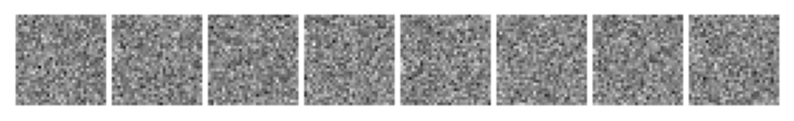

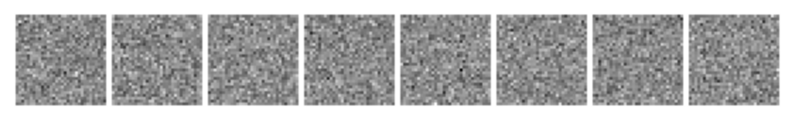

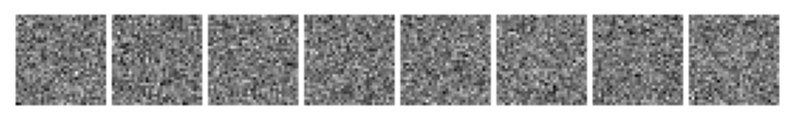

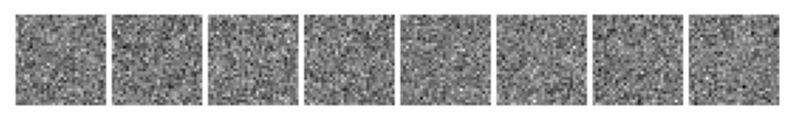

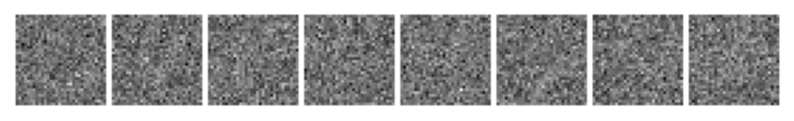

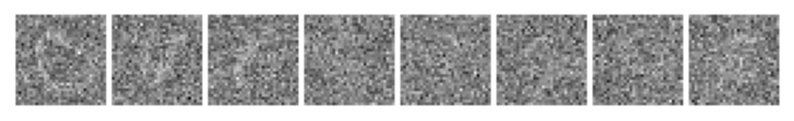

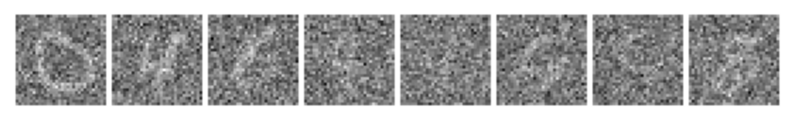

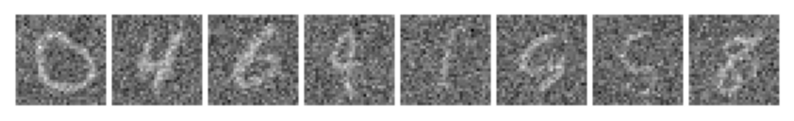

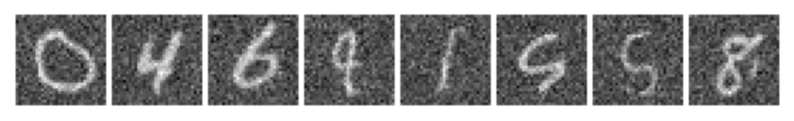

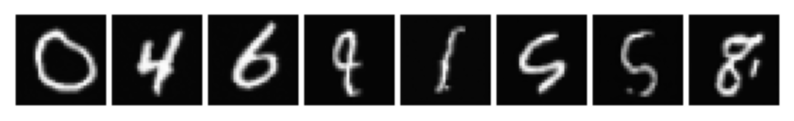

In [34]:
from torchvision.utils import make_grid
for i, frame in enumerate(samples):
    frame = torch.from_numpy(frame)  
    grid = make_grid(frame, nrow=8, normalize=True, pad_value=1) 

    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.axis("off")
    

## MNIST : fashion

In [3]:
!python ddpm.py --dataset fashion-mnist --experiment_name fashion-mnist_base --train_batch_size 64 --num_epochs 20 --learning_rate 1e-4 --eval_batch_size 5 --embedding_size 256

Training model...
GPU name: NVIDIA RTX A2000 12GB 

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.89it/s]
Saving model...
Saving images...
Saving loss as numpy array...
Saving frames...


In [6]:
model = ddpm.UNet(256, 1, 1)

path = "exps/fashion-mnist_base/model.pth"
model.load_state_dict(torch.load(path))
model.eval()

/tmp/ipykernel_428165/714004818.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


UNet(
  (inp): ResBlock(
    (resnet_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): SiLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GroupNorm(8, 64, eps=1e-05, affine=True)
    )
  )
  (down1): DownBlock(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ResBlock(
        (resnet_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (2): SiLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        )
      )
      (2): ResBlock(
        (resnet_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Grou

In [7]:
eval_batch_size = 8
num_timesteps = 1000

plot_step = 100
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
sample = torch.randn(eval_batch_size, 1, 32, 32) 
timesteps = list(range(num_timesteps))[::-1]
samples = []
steps = []
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        residual = model(sample, t)
    sample = noise_scheduler.step(residual, t[0], sample)
    if (i + 1) % plot_step == 0:
        samples.append(sample.cpu().numpy())
        steps.append(i + 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

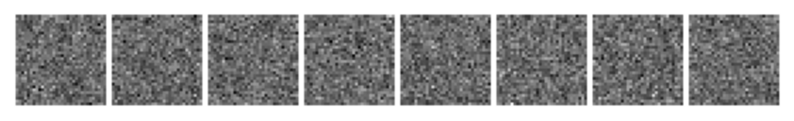

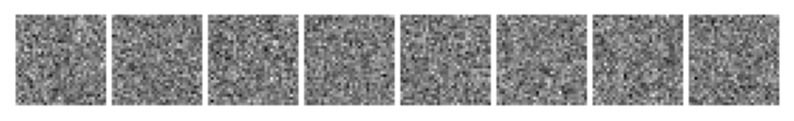

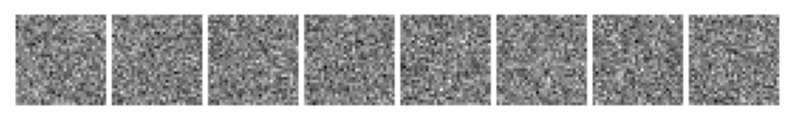

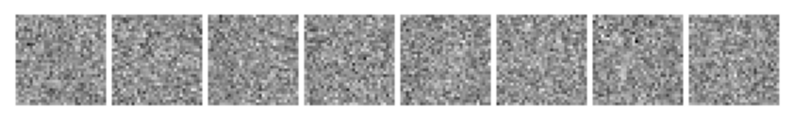

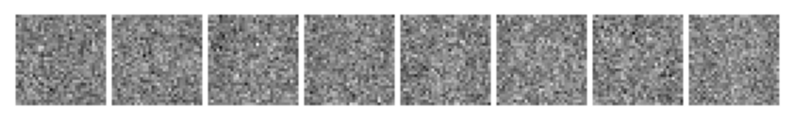

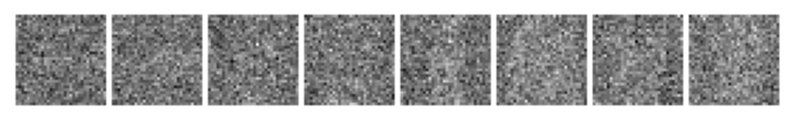

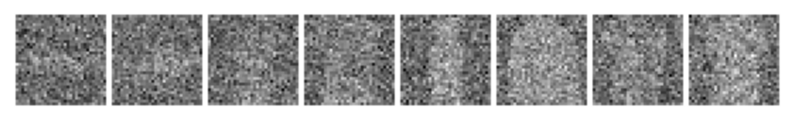

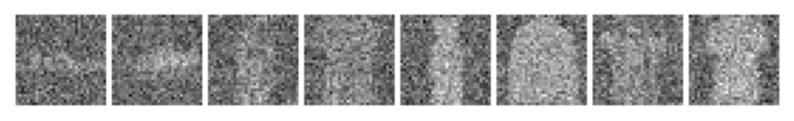

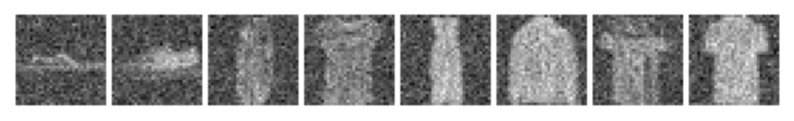

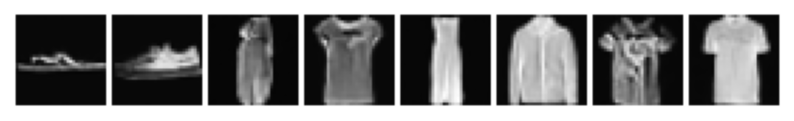

In [8]:
for i, frame in enumerate(samples):
    frame = torch.from_numpy(frame) 
    grid = make_grid(frame, nrow=8, normalize=True, pad_value=1)  

    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.axis("off")
    

## Pets 

### OxfordIIITPet dataset

In [29]:
!python ddpm.py --dataset pets --experiment_name pets_base --train_batch_size 64 --num_epochs 100 --learning_rate 1e-4 --eval_batch_size 5 --embedding_size 256

Training model...
GPU name: NVIDIA RTX A2000 12GB 

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.13it/s]
Saving model...
Saving images...
Saving loss as numpy array...
Saving frames...


In [30]:
model = ddpm.UNet(256, 3, 3)

path = "exps/pets_base/model.pth"
model.load_state_dict(torch.load(path))
model.eval()

/tmp/ipykernel_428165/2359398274.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


UNet(
  (inp): ResBlock(
    (resnet_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): SiLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GroupNorm(8, 64, eps=1e-05, affine=True)
    )
  )
  (down1): DownBlock(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ResBlock(
        (resnet_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (2): SiLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        )
      )
      (2): ResBlock(
        (resnet_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Grou

In [31]:
eval_batch_size = 8
num_timesteps = 1000

plot_step = 100
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
sample = torch.randn(eval_batch_size, 3, 32, 32) 
timesteps = list(range(num_timesteps))[::-1]
samples = []
steps = []
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        residual = model(sample, t)
    sample = noise_scheduler.step(residual, t[0], sample)
    if (i + 1) % plot_step == 0:
        samples.append(sample.cpu().numpy())
        steps.append(i + 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

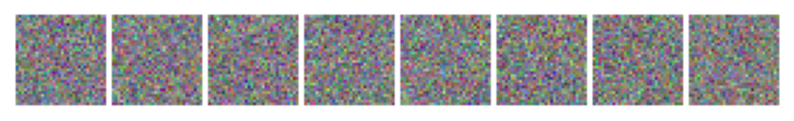

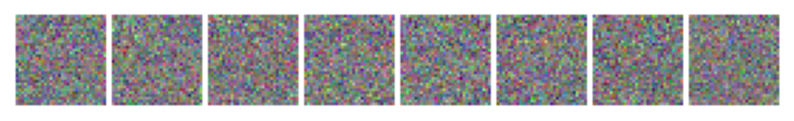

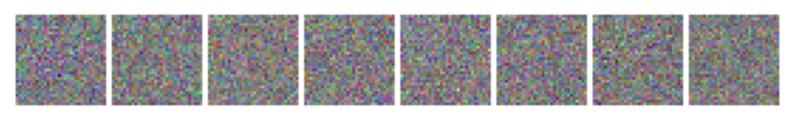

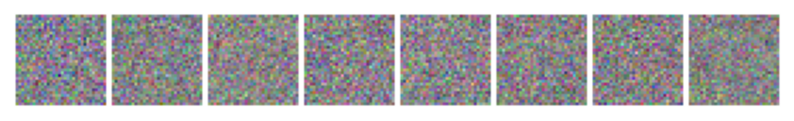

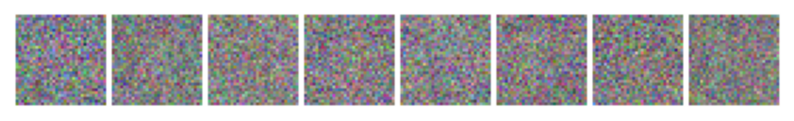

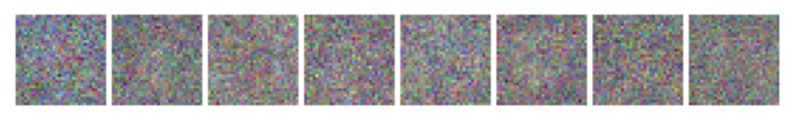

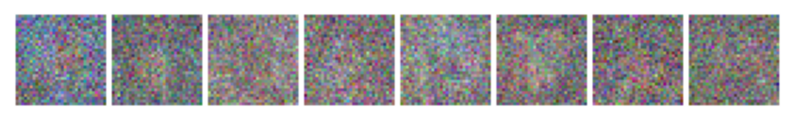

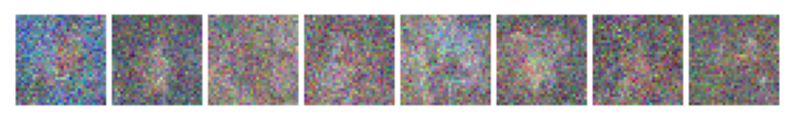

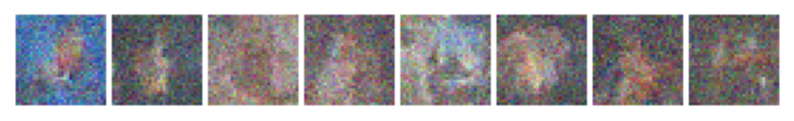

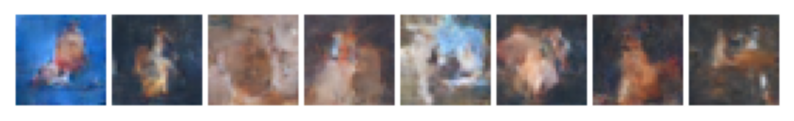

In [32]:

for i, frame in enumerate(samples):
    frame = torch.from_numpy(frame) 
    grid = make_grid(frame, nrow=8, normalize=True, pad_value=1) 

    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.axis("off")
    

### Private Kaggle dataset

In [15]:
!python ddpm.py --dataset pets --experiment_name pets_base --train_batch_size 64 --num_epochs 75 --learning_rate 1e-4 --eval_batch_size 5 --embedding_size 256

Training model...
GPU name: NVIDIA RTX A2000 12GB 

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.35it/s]
Saving model...
Saving images...
Saving loss as numpy array...
Saving frames...


In [3]:
model = ddpm.UNet(256, 3, 3)

path = "exps/pets_base/model.pth"
model.load_state_dict(torch.load(path))
model.eval()

/tmp/ipykernel_536658/2359398274.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


UNet(
  (inp): ResBlock(
    (resnet_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): SiLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GroupNorm(8, 64, eps=1e-05, affine=True)
    )
  )
  (down1): DownBlock(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ResBlock(
        (resnet_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (2): SiLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        )
      )
      (2): ResBlock(
        (resnet_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Grou

In [4]:
eval_batch_size = 8
num_timesteps = 1000

plot_step = 100
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
sample = torch.randn(eval_batch_size, 3, 32, 32) 
timesteps = list(range(num_timesteps))[::-1]
samples = []
steps = []
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        residual = model(sample, t)
    sample = noise_scheduler.step(residual, t[0], sample)
    if (i + 1) % plot_step == 0:
        samples.append(sample.cpu().numpy())
        steps.append(i + 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

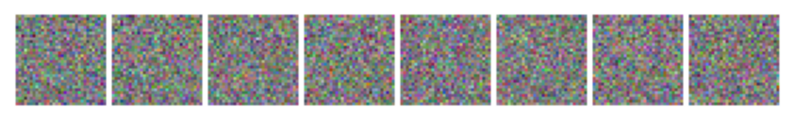

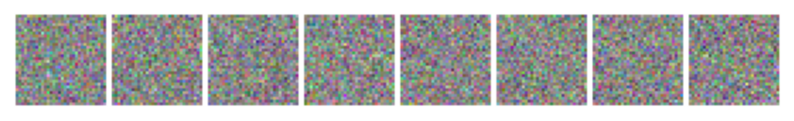

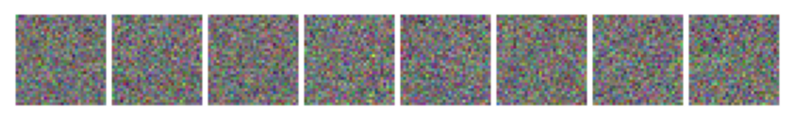

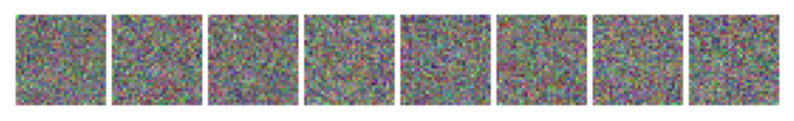

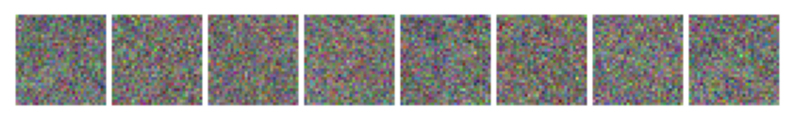

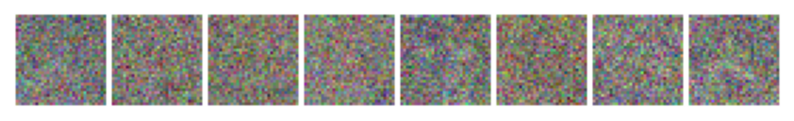

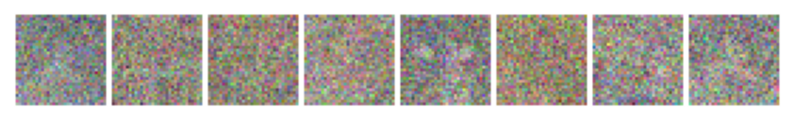

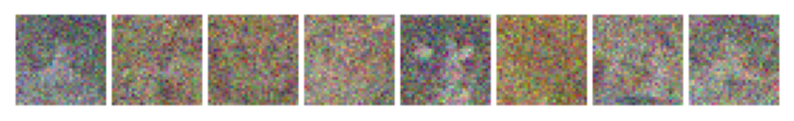

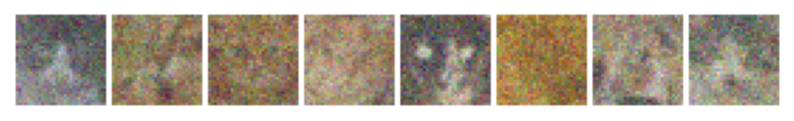

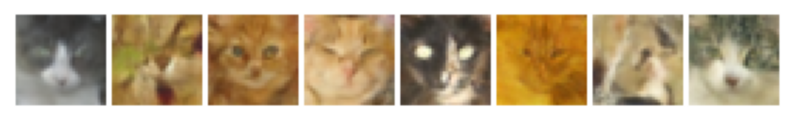

In [5]:
for i, frame in enumerate(samples):
    frame = torch.from_numpy(frame) 
    grid = make_grid(frame, nrow=8, normalize=True, pad_value=1)  

    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.axis("off")
    

### Human faces 

In [24]:
!python ddpm.py --dataset faces --experiment_name faces_base --train_batch_size 32 --num_epochs 22 --learning_rate 1e-4 --eval_batch_size 5 --embedding_size 256

Training model...
GPU name: NVIDIA RTX A2000 12GB 

100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 105.33it/s]
Saving model...
Saving images...
Saving loss as numpy array...
Saving frames...


In [28]:
model = ddpm.UNet(256)

path = "exps/faces_base/model.pth"
model.load_state_dict(torch.load(path))
model.eval()

/tmp/ipykernel_578194/752514893.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


UNet(
  (inp): ResBlock(
    (resnet_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): SiLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GroupNorm(8, 64, eps=1e-05, affine=True)
    )
  )
  (down1): DownBlock(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ResBlock(
        (resnet_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (2): SiLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        )
      )
      (2): ResBlock(
        (resnet_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Grou

In [31]:
eval_batch_size = 5
num_timesteps = 1000

plot_step = 100
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
sample = torch.randn(eval_batch_size, 3, 32, 32) 
timesteps = list(range(num_timesteps))[::-1]
samples = []
steps = []
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        residual = model(sample, t)
    sample = noise_scheduler.step(residual, t[0], sample)
    if (i + 1) % plot_step == 0:
        samples.append(sample.cpu().numpy())
        steps.append(i + 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

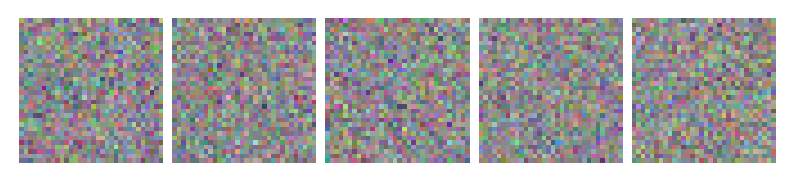

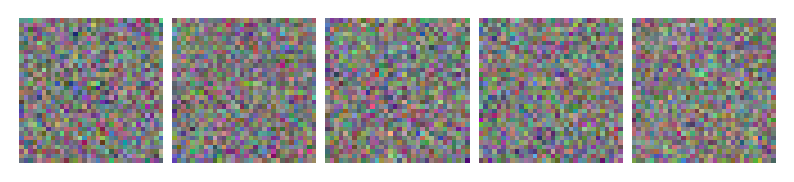

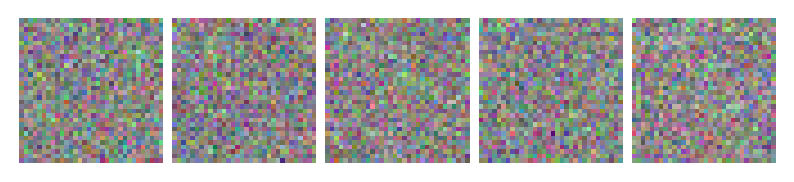

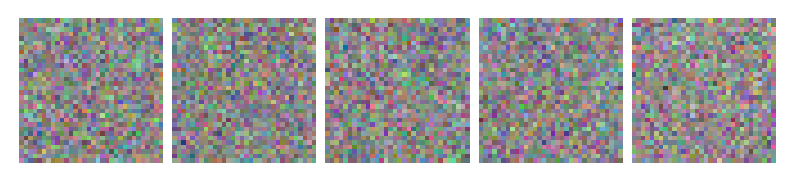

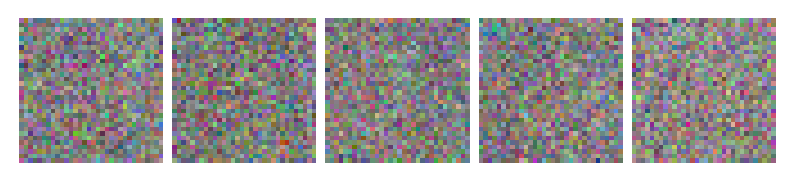

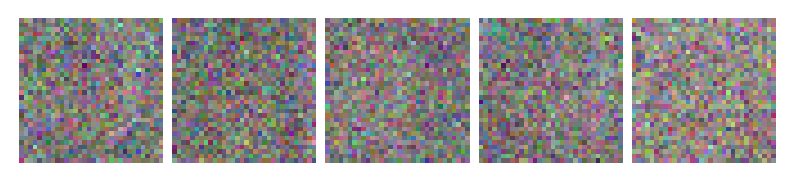

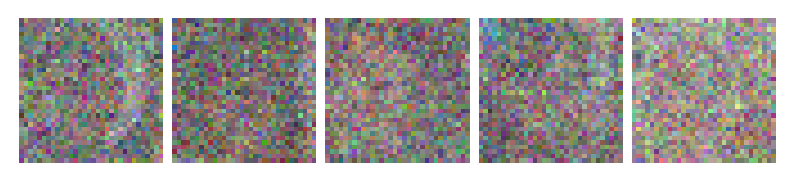

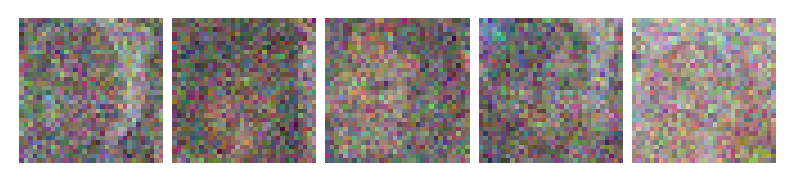

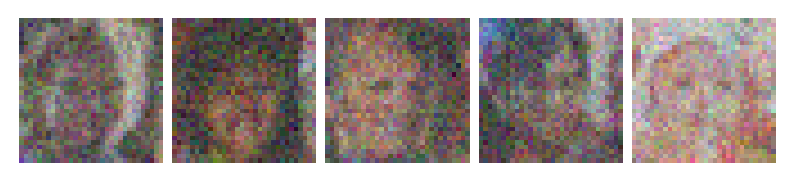

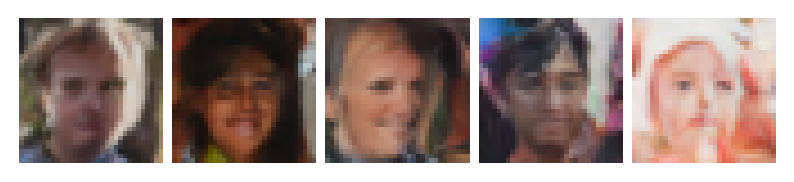

In [32]:
for i, frame in enumerate(samples):
    frame = torch.from_numpy(frame)  
    grid = make_grid(frame, nrow=8, normalize=True, pad_value=1) 

    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.axis("off")
    

# Audio diffusion

In [ ]:

!python ddpm.py --dataset speech-commands --experiment_name speech-commands_base --train_batch_size 64 --num_epochs 40 --learning_rate 1e-4 --embedding_size 256

Dataset déjà présent. Chargement en cours...
Training model...
GPU name: NVIDIA RTX A2000 12GB 

Epoch 39: 100%|██████| 607/607 [03:54<00:00,  2.59it/s, loss=0.0758, step=24279]
Saving model...
Saving loss as numpy array...
Saving frames...


In [20]:
model = ddpm.UNet(256,1,1)

path = "exps/speech-commands_base/model.pth"
model.load_state_dict(torch.load(path))
model.eval()

UNet(
  (time_embedding): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (inp): ResBlock(
    (resnet_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): SiLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GroupNorm(8, 64, eps=1e-05, affine=True)
    )
  )
  (down1): DownBlock(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ResBlock(
        (resnet_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (2): SiLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        )
      )
      (2): ResBlock(
        (resnet_conv): Sequential(
          (0): Conv2d

In [21]:
def mel_to_audio(mel_spectrogram, n_iter=200, sample_rate=8000):
    """
    Convertit un Mel spectrogramme en audio à l'aide de l'algorithme Griffin-Lim.
    """
    mel_spectrogram = torch.tensor(mel_spectrogram).cpu().numpy()
    
    audio = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sample_rate, n_iter=n_iter)
    
    return audio

In [22]:
eval_batch_size = 1
num_timesteps = 1000
plot_step = 100
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
sample = torch.randn(eval_batch_size, 1, 32, 41)  # (mel spectrogramme de taille [8, 1, 32, 41])
timesteps = list(range(num_timesteps))[::-1]
samples = []
steps = []

for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        residual = model(sample, t) 
    sample = noise_scheduler.step(residual, t[0], sample)  
    if (i + 1) % plot_step == 0:
        samples.append(sample.cpu().numpy())  
        steps.append(i + 1)
        for j in range(eval_batch_size):
            mel = samples[-1][j, 0, :, :]  
            audio = mel_to_audio(mel)  
            output_filename = f"exps/speech-commands_base/audio/generated_audio_step_{i+1}_batch_{j+1}.wav"
            sf.write(output_filename, audio, 8000) 
            print(f"Audio sauvegardé : {output_filename}")


  0%|          | 0/1000 [00:00<?, ?it/s]

Audio sauvegardé : exps/speech-commands_base/audio/generated_audio_step_100_batch__1.wav
Audio sauvegardé : exps/speech-commands_base/audio/generated_audio_step_200_batch__1.wav
Audio sauvegardé : exps/speech-commands_base/audio/generated_audio_step_300_batch__1.wav
Audio sauvegardé : exps/speech-commands_base/audio/generated_audio_step_400_batch__1.wav
Audio sauvegardé : exps/speech-commands_base/audio/generated_audio_step_500_batch__1.wav
Audio sauvegardé : exps/speech-commands_base/audio/generated_audio_step_600_batch__1.wav
Audio sauvegardé : exps/speech-commands_base/audio/generated_audio_step_700_batch__1.wav
Audio sauvegardé : exps/speech-commands_base/audio/generated_audio_step_800_batch__1.wav
Audio sauvegardé : exps/speech-commands_base/audio/generated_audio_step_900_batch__1.wav
Audio sauvegardé : exps/speech-commands_base/audio/generated_audio_step_1000_batch__1.wav
